# Model Testing Notebook

## Objectives

* Model performance evaluation, extract the images from the test/ folder and run the model through it.
* Feature extraction and prediction with custom input and visualization.
* Execute a f1-score report.


## Inputs

* test/
* tailteller_model.keras
* labels.csv

## Outputs

* test_predict
* 3 different plots from a single dog image
* f1-score report
  


---

In [4]:
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
from keras.models import load_model
import pickle
import gc
from keras.models import load_model
from tqdm.autonotebook import tqdm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import load_img
import numpy as np
from keras.layers import Input, Lambda, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from keras.applications import InceptionV3, Xception, NASNetLarge, InceptionResNetV2
from keras.applications.inception_v3 import preprocess_input as inception_preprocessor
from keras.applications.xception import preprocess_input as xception_preprocessor
from keras.applications.nasnet import preprocess_input as nasnet_preprocessor
from keras.applications.inception_resnet_v2 import preprocess_input as inc_resnet_preprocessor


# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/home/jaaz/Desktop/project-5/TailTeller/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("New current directory:", os.getcwd())

New current directory: /home/jaaz/Desktop/project-5/TailTeller


---

### Let's load the get_features function again in order to run the dog images in the train/ folder through the models we already know. This folder was untouched until now and will be used from now on to see how our model performs.

In [4]:
img_size = (299,299,3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    #Extract feature
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

# Let's read the images from the test directory

Creating a function to load the images in the train/ folder, pre-process them into a numpy array and also return the corresponding ids (breed labels) before extracting the features:

In [5]:
def load_test_images(data_dir, img_size=(299, 299, 3)):
    """
    This function loads and processes images from the test/ directory into a numpy array
    Parameters:
        test_dir: str, path to the directory containing the test images
        img_size: tuple, size to which the images should be resized (width, height, channels)
    Returns:
        A numpy array containing the processed images
        A list of filenames (ids) of the images
    """
    # Making the full file paths for each image in the test directory
    test_filenames = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir)]

    # Determine the number of images
    data_size = len(test_filenames)

    #Preallocate a numpy array to hold all images
    images = np.zeros((data_size, img_size[0], img_size[1], img_size[2]), dtype=np.uint8)
    
    #Load each image, resize it and store it in the preallocated array
    for ix, img_path in enumerate(tqdm(test_filenames, desc="Processing images")):
        img = load_img(img_path, target_size=img_size)
        images[ix] = img
        # Free RAM
        del img
    
    # Display the final data size
    print(f"Final data size {images.shape}")

    # Extract ids from filenames
    ids = [os.path.basename(fname).split('.')[0] for fname in test_filenames]

    return images, ids

Assigning the numpy array transformed 5111 training images plus the ids into the test_data variable:

In [6]:
test_data, ids = load_test_images('images/test/')

# Save the ids to a pickle file
with open('ids.pkl', 'wb') as f:
    pickle.dump(ids, f)

Processing images: 100%|██████████| 5111/5111 [00:03<00:00, 1292.33it/s]

Final data size (5111, 299, 299, 3)


This function will extract the features taking the same models we've used before and return a variable concatenating all the 4 model features:

In [7]:
def extract_features(data, img_size=(299, 299, 3)):
    """
    Extracts features from test data using multiple pre-trained models 
    and concatenate them
    Parameters:
        data: numpy array, the input data we need to extract features from
        img_size: tuple, size to which the images
        should be resized (width, height, channels)
    Returns:
        a numpy array containing concatenated features from multiple models
    """
    # Extract features using InceptionV3
    inception_features = get_features(InceptionV3, inception_preprocessor, img_size, data)

    # Extract features using Xception
    xception_features = get_features(Xception, xception_preprocessor, img_size, data)

    # Extract features using NASNetLarge
    nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, img_size, data)

    # Extract features using InceptionResNetV2
    inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, img_size, data)

    # Concatenate all extracted features along the last axis
    final_features = np.concatenate(
        [inception_features, xception_features, nasnet_features, inc_resnet_features],
        axis=-1
    )

    # Free RAM
    del inception_features, xception_features, nasnet_features, inc_resnet_features
    gc.collect()

    return final_features

Assigning the extracted features from test_data (the dog pictures inside train/) into the test_features variable:

In [8]:
test_features = extract_features(test_data)

160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 510ms/step
Feature maps shape:  (5111, 2048)
160/160 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step
Feature maps shape:  (5111, 2048)
160/160 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step
Feature maps shape:  (5111, 4032)
160/160 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step
Feature maps shape:  (5111, 1536)


Let's load our tailteller Keras model and use the predict function to generate predictions for the input samples in the dataset.

In [9]:
model = load_model('src/machine_learning/tailteller_model.keras')
# Predict test labels given test data features.
test_predict = model.predict(test_features)

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step


In [10]:
# Save the predictions to a pickle file
with open('test_predict.pkl', 'wb') as f:
    pickle.dump(test_predict, f)

# softmax usage
We are now taking the first [0] image test into our prediction and doing the following:

1. Print prediction results for the set of input features.
2. Print the highest probability in the prediction array.
3. Since softmax was used in the output layer of the model the sum of all probabilities should be 1 or extremely close.
4. Print the index (dog breed label index) with the maximum probability.
5. Load the breed file and predict the label with the number printed on point 4.

In [11]:
# First prediction
print(f"{test_predict[0]}")
# Display the predicted label
print(f"Max value (probability of prediction): {np.max(test_predict[0])}")
# Display the sum of all values
print(f"Sum: {np.sum(test_predict[0])}")
# Display the index of the max value
print(f"Max index: {np.argmax(test_predict[0])}")

with open('breeds.pkl', 'rb') as f:
    breeds = pickle.load(f)
# Display the breed of the predicted label
print(f"Predicted label: {breeds[np.argmax(test_predict[0])]}")




[2.35808685e-07 1.68270461e-07 3.80535823e-07 1.16903330e-07
 9.96165276e-01 2.76171941e-05 2.63248694e-06 6.37945504e-06
 8.02516027e-08 5.11466055e-07 1.01161930e-07 3.34104797e-08
 6.57595649e-08 1.25636589e-07 5.10398230e-08 2.07062408e-06
 3.08762137e-05 4.51610106e-07 5.80154556e-08 2.01797557e-05
 4.23330960e-07 7.38907102e-06 6.35541397e-08 5.44295240e-08
 9.87123371e-07 1.57922921e-06 1.61340802e-06 1.61808464e-06
 1.29744149e-06 3.40061604e-07 2.48464801e-07 1.00372006e-07
 1.04491676e-07 1.01845308e-06 3.38056623e-08 2.67287277e-07
 1.29673401e-06 4.14713850e-06 1.33227536e-06 2.53217507e-07
 3.56842037e-07 3.25140206e-07 6.94532565e-09 1.14923769e-05
 3.72878901e-07 1.57671457e-06 5.38141833e-08 5.60367425e-07
 8.44524095e-08 2.79135435e-07 2.63513407e-08 4.70732848e-05
 1.47235795e-07 3.21958487e-06 3.93271726e-08 4.18149682e-07
 3.75443761e-07 4.50747820e-07 9.29380661e-08 1.77540002e-07
 4.22038420e-06 3.03568470e-07 7.10974817e-08 6.66766800e-06
 4.54951220e-07 9.473916

### Now let's see the image we have just predicted:

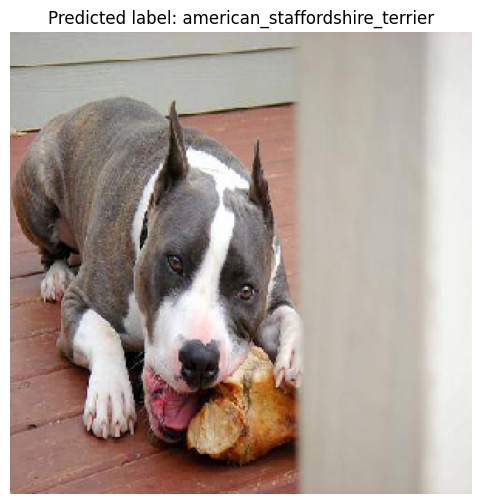

In [12]:
img_to_show = test_data[0].astype('uint8')

plt.figure(figsize=(6,6))
plt.imshow(img_to_show)
plt.title(f"Predicted label: {breeds[np.argmax(test_predict[0])]}")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

Now I will choose a random picture from the test folder and feed into our model to see predictions:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
Feature maps shape:  (1, 2048)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
Feature maps shape:  (1, 2048)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Feature maps shape:  (1, 4032)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Feature maps shape:  (1, 1536)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predicted label: norfolk_terrier
Probability of prediction: 100%


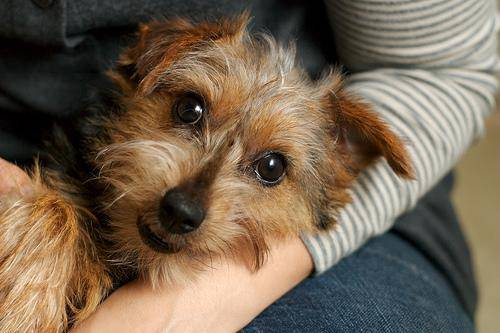

In [13]:
random_dog = load_img('images/test/dab33799bceb2387a3daea652bfd8773.jpg', target_size=(299, 299, 3))

random_dog = np.expand_dims(random_dog, axis=0)
features = extract_features(random_dog)
predict_dog = model.predict(features)
print(f"Predicted label: {breeds[np.argmax(predict_dog[0])]}")
print(f"Probability of prediction: {round(np.max(predict_dog[0])*100)}%")
Image('images/test/dab33799bceb2387a3daea652bfd8773.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
Feature maps shape:  (1, 2048)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
Feature maps shape:  (1, 2048)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Feature maps shape:  (1, 4032)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Feature maps shape:  (1, 1536)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


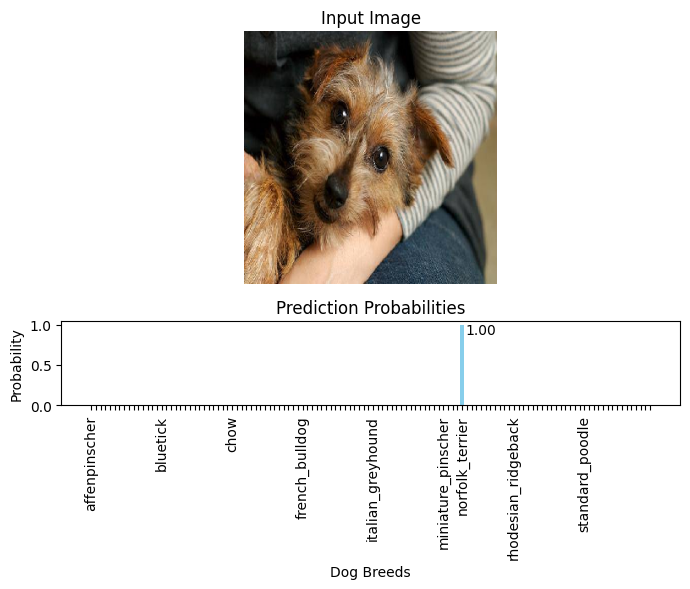

In [14]:
def load_and_prepare_image(image_path, target_size=(299, 299)):
    """ Load and prepare an image for prediction """
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def make_prediction(model, img_array):
    """ Make a prediction and return probabilities """
    features = extract_features(img_array)
    predictions = model.predict(features)
    return predictions

def plot_predictions(image_path, model, breeds):
    """ Load an image, make a prediction, and plot the results """
    img_array = load_and_prepare_image(image_path)
    predictions = make_prediction(model, img_array)

    # Get the breed with the highest predicted probability
    top_breed_index = np.argmax(predictions[0])
    top_breed = breeds[top_breed_index]
    
    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(7,6), gridspec_kw={'height_ratios': [3, 1]})
    
    axs[0].imshow(img_array[0].astype('uint8'))
    axs[0].set_title('Input Image')
    axs[0].axis('off')
    
    axs[1].bar(range(len(breeds)), predictions[0], color='skyblue')
    axs[1].set_title('Prediction Probabilities')
    axs[1].set_xlabel('Dog Breeds')
    axs[1].set_ylabel('Probability')
    
    # Show only every nth label and the top breed label
    n = 15
    labels = [breed if i % n == 0 or breed == top_breed else '' for i, breed in enumerate(breeds)]
    axs[1].set_xticks(range(len(breeds)))
    axs[1].set_xticklabels(labels, rotation=90)

    # Add the probability value next to the bar for the top breed
    axs[1].text(top_breed_index + 0.6, predictions[0][top_breed_index] - 0.06, f'{predictions[0][top_breed_index]:.2f}', ha='left', va='center')
    
    plt.tight_layout()
    plt.show()

image_path = 'images/test/dab33799bceb2387a3daea652bfd8773.jpg'
plot_predictions(image_path, model, breeds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
Feature maps shape:  (1, 2048)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
Feature maps shape:  (1, 2048)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Feature maps shape:  (1, 4032)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Feature maps shape:  (1, 1536)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


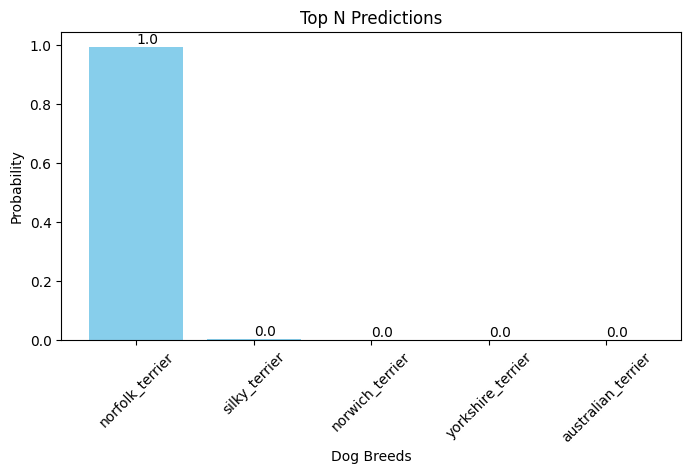

In [15]:
def plot_top_n_predictions(predictions, breeds, n=5):
    """ Plot bar chart of the top N predictions """
    # Get indices of the top N probabilities
    top_n_indices = np.argsort(predictions[0])[-n:][::-1]
    top_n_probs = predictions[0][top_n_indices]
    top_n_breeds = [breeds[i] for i in top_n_indices]
    
    plt.figure(figsize=(8, 4))
    bars = plt.bar(top_n_breeds, top_n_probs, color='skyblue')
    plt.xlabel('Dog Breeds')
    plt.ylabel('Probability')
    plt.title('Top N Predictions')
    plt.xticks(rotation=45)

    # Add a text label above each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')  # va: vertical alignment

    plt.show()
    
img_array = load_and_prepare_image(image_path)
predictions = make_prediction(model, img_array)
plot_top_n_predictions(predictions, breeds, n=5)




## Processing and filter the true labels data from the training dataset to prepare for the model accuracy F1-Score
* Getting the labels in the labels.csv file
* transforming into a DataFrame
* Grab only the labels existing in ids (the dog labels returned from loading the test images)
* Get the ids and transform into a DataFrame
* Merging both ids_df and filtered_labels so they are exactly in the same order
* Extract the breed column into a numpy array, containing the true labels corresponding to the ids in the original order.

In [5]:
with open('ids.pkl', 'rb') as f:
    ids = pickle.load(f)

# Load the CSV file
labels_df = pd.read_csv('labels.csv')

filtered_labels = labels_df[labels_df['id'].isin(ids)]

ids_df = pd.DataFrame(ids, columns=['id'])

filtered_labels_ordered = pd.merge(ids_df, filtered_labels, on='id')

y_true_filtered = filtered_labels_ordered['breed'].values



### We are making the F1-Score here, if this report is a high score it serves as to measure how well the model is able to correctly identify specific breed in the following way:

* For example one of the breeds of our model is the Labrador, if the f1-score is high, the model is both good at correctly identifying Labradors and also good at not missing any Labradors in the dataset.

1. Let's use both the labels from our test dataset (y_pred) and the true labels for this dataset (y_true_filtered).

2. The only thing we have to do now is encode these labels because they still are names of dog breeds, we need to transform them into numbers so the algorithm can check against the predicted y labels (y_pred) which is already an array of numbers.

In [7]:
with open('test_predict.pkl', 'rb') as f:
    test_predict = pickle.load(f)

# Generate model predictions
y_pred = test_predict
y_pred = np.argmax(y_pred, axis=1)


# Initialize the label encoder
le = LabelEncoder()

# Fit the label encoder and transform y_true_filtered to get encoded labels
y_true_filtered_encoded = le.fit_transform(y_true_filtered)

# Generate classification report
report = classification_report(y_true_filtered_encoded, y_pred)
print(report)

# Calculate accuracy
accuracy = accuracy_score(y_true_filtered_encoded, y_pred)
print('Accuracy:', accuracy)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95        45
           1       1.00      0.99      0.99        68
           2       0.97      0.97      0.97        40
           3       0.94      0.96      0.95        53
           4       0.74      0.74      0.74        38
           5       0.92      0.87      0.89        39
           6       0.82      0.91      0.86        64
           7       0.98      0.98      0.98        49
           8       1.00      1.00      1.00        40
           9       0.93      0.97      0.95        59
          10       1.00      1.00      1.00        43
          11       0.94      0.97      0.95        61
          12       0.95      0.95      0.95        40
          13       1.00      0.98      0.99        47
          14       0.93      1.00      0.96        37
          15       0.96      0.98      0.97        44
          16       0.84      0.88      0.86        43
          17       0.96    

About the report:

* Precision: The ability of the classifier not to label negative sample as positive.
* Recall: The ability of the classifier to find all positive instances.
* F1-Score: The harmonic mean of precision and recall, it finds the balance between them both.

**Accuracy of the model: 92,6%.**



# Conclusions

- To conclude the documentation of the our machine learning model to predict dog breeds, there are a few remarks:

    * Model Evaluation: The processing of the images and passing through the various pre-trained models were effective but also time costly as tensorflow as I'm writing this doesn't support my AMD GPU (the 7800XT) even with ROCM. So I had to handle everything with my CPU, thankfully mine handled it well, still running through these 5111 images take about 13 minutes and 40 seconds.

    * Predictive Performance: As we verified earlier, our model does a real-world accuracy of 93%, taking in consideration it was trained in only 120 breeds, with only 27 samples on the lowest breed count (boxer) and 70 on the highest (entlebucher). For a client, it's usually better to have a minimum of 1000 samples from each breed and a much higher count of unique breed labels.

    * Model Errors: To have in consideration that there could be discrepancies if the uploader tries to predict for example a mixed dog, a dog breed which wasn't trained, or a bad quality image.

---